# **Logistic Regression, Random Forest, or KNN**

_John Andrew Dixon_

---

**Setup**

In [74]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay

In [75]:
# Remote url to the dataset
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTvYsiM0huszmpSKoHmkPURxSeCGxnCL0dPSMngtc_ij2E3jXgsd7Cqj4c6zxauMqYyEQWIcwo9X1hd/pub?output=csv"
# Load the dataset
df = pd.read_csv(url)
# Verify it loaded by viewing info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

---

## **Tasks**

### **Logistic Regression**

#### Baseline

In [77]:
# Create the feature matrix
X = df.drop(columns=["id", "diagnosis"])
# Create the target vector
y = df["diagnosis"]
# Create the train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [78]:
# Create a standard scaler
scaler = StandardScaler()
# Create a logistic regression model
lor = LogisticRegression(random_state=42)
# Create a logistic regression pipeline
lor_pipeline = make_pipeline(scaler, lor)

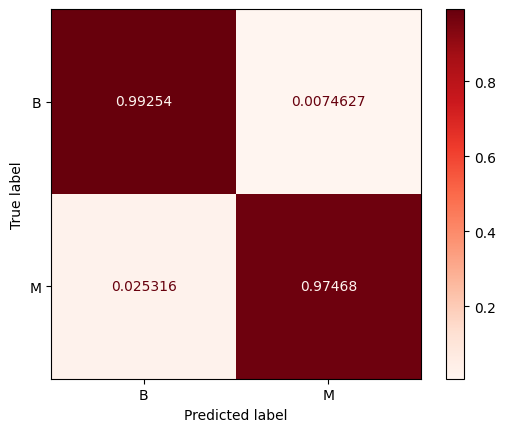

In [94]:
# Fit and evaluate
lor_pipeline.fit(X_train, y_train)
ConfusionMatrixDisplay.from_predictions(
    y_train, 
    lor_pipeline.predict(X_train),
    cmap="Reds",
    normalize="true",
    values_format=".5g"
);


#### **Tuning L1 _and_ L2**